# EDA (TUR-729)

- Data from `wx-bq-poc.wx_lty_digital_attribution_dev.tealium_events`
- Plenty of records that can be used as indicators of what are being searched.
- Coverage available from August 2019
- Phrases are common - can be broken down into words to get better word clustering
- Cases will need to be handled properly - can get better word clustering as well

Supposedly we can embed these words (subword embedding like or even simple word2vec) and find similarity score with the embedded product metadata (Lindt --> chocolate, balls, etc), then match-make that way?


In [1]:
import os
os.environ['GOOGLE_APPLICATION_CREDENTIALS']=f"/home/jovyan/.config/gcloud/legacy_credentials/{os.getenv('JUPYTERHUB_USER')}/adc.json" 

import pandas as pd
import numpy as np

from google.cloud import bigquery
import matplotlib.pyplot as plt

plt.rcParams['axes.grid'] = True
bq = bigquery.Client(project='wx-bq-poc')

In [2]:
def get_dataframe(sql):
    df = bq.query(sql).result().to_dataframe()
    return df    

### Number of records

In [3]:
sql = '''
    select 
        count(*) n_records,
        count(distinct udo_search_keyword_5172) n_keywords
    from `wx-bq-poc.wx_lty_digital_attribution_dev.tealium_events`
    where udo_search_keyword_5172 is not null; 
'''
get_dataframe(sql)

n_records  n_keywords
0  947512361    20243940

### Time coverage

In [4]:
sql = '''
    select 
        min(post_time) min_post_time,
        max(post_time) max_post_time
    from `wx-bq-poc.wx_lty_digital_attribution_dev.tealium_events`
    where udo_search_keyword_5172 is not null;
'''
get_dataframe(sql)

min_post_time             max_post_time
0 2019-08-16 06:17:38+00:00 2021-05-17 23:59:59+00:00

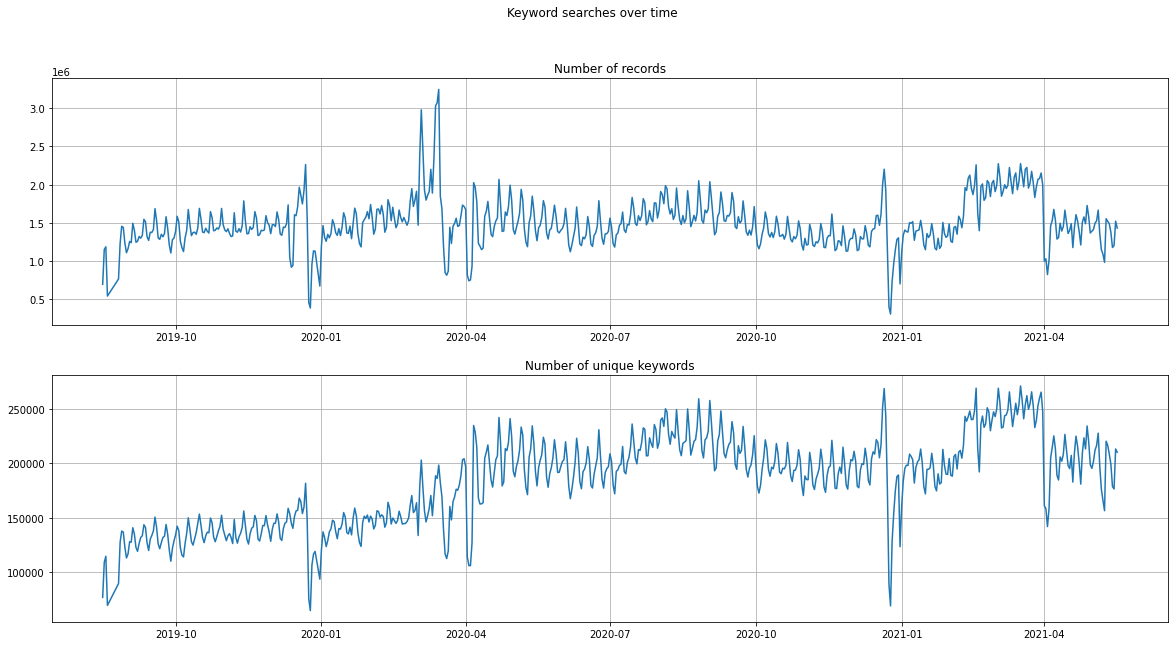

In [5]:
sql = '''
    select 
        date(post_time) as post_date,
        count(*) n_records,
        count (distinct udo_search_keyword_5172) n_keywords
    from `wx-bq-poc.wx_lty_digital_attribution_dev.tealium_events`
    where udo_search_keyword_5172 is not null
    group by 1 order by 1;
'''
df = get_dataframe(sql)

fig, ax = plt.subplots(2, 1, figsize=(20, 10))
ax[0].plot(df['post_date'], df['n_records'])
ax[0].set_title('Number of records')
ax[1].plot(df['post_date'], df['n_keywords'])
ax[1].set_title('Number of unique keywords')
fig.suptitle('Keyword searches over time')
plt.show()

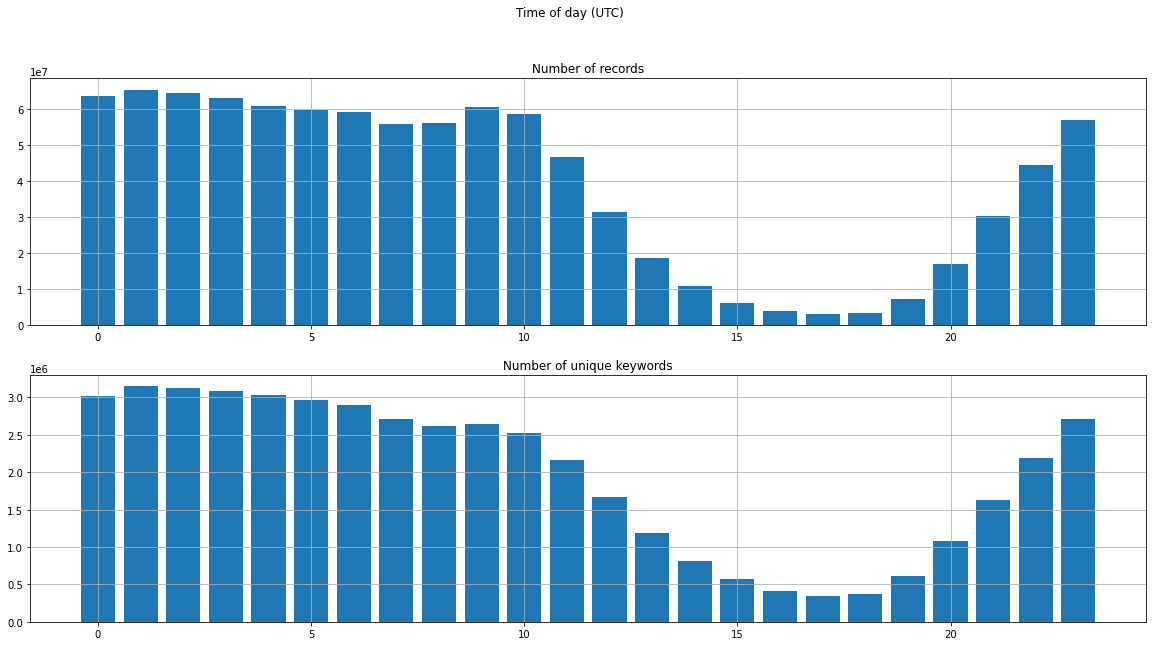

In [6]:
sql = '''
    select 
        extract(hour from post_time) as post_hour,
        count(*) n_records, 
        count (distinct udo_search_keyword_5172) n_keywords
    from `wx-bq-poc.wx_lty_digital_attribution_dev.tealium_events`
    where udo_search_keyword_5172 is not null
    group by 1 order by 1;
'''
df = get_dataframe(sql)

fig, ax = plt.subplots(2, 1, figsize=(20, 10))
ax[0].bar(df['post_hour'], df['n_records'])
ax[0].set_title('Number of records')
ax[1].bar(df['post_hour'], df['n_keywords'])
ax[1].set_title('Number of unique keywords')
fig.suptitle('Time of day (UTC)')
plt.show()

### Top keyword searches

In [7]:
sql = '''
    select 
        count(*) n_records
    from `wx-bq-poc.wx_lty_digital_attribution_dev.tealium_events`
'''
n_records = get_dataframe(sql)['n_records'][0]

sql = '''
    select 
        udo_search_keyword_5172, 
        count(*) n_records
    from `wx-bq-poc.wx_lty_digital_attribution_dev.tealium_events`
    where udo_search_keyword_5172 is not null
    group by 1 order by 2 desc
    limit 20;
'''
df = get_dataframe(sql)
df['p_records'] = df['n_records'] / n_records
df

udo_search_keyword_5172  n_records  p_records
0                     Milk    4606649   0.000340
1                     milk    3902738   0.000288
2                    Bread    3245479   0.000239
3                    bread    2912512   0.000215
4                  Yoghurt    2818939   0.000208
5                    mince    2771256   0.000204
6                     eggs    2746684   0.000203
7                     Eggs    2734639   0.000202
8             toilet paper    2636771   0.000194
9                   Cheese    2602807   0.000192
10                 Chicken    2513882   0.000185
11                  cheese    2457417   0.000181
12                   Chips    2434935   0.000180
13               chocolate    2421932   0.000179
14            Toilet Paper    2295838   0.000169
15                   chips    2292109   0.000169
16                 chicken    2276044   0.000168
17                   pasta    2266910   0.000167
18                   bacon    2192842   0.000162
19          chicken breast    2179228   0.000161

In [8]:
sql = '''
    select 
        udo_search_keyword_5172, 
        count(*) n_records
    from `wx-bq-poc.wx_lty_digital_attribution_dev.tealium_events`
    where udo_search_keyword_5172 is not null
    group by 1 order by 2
    limit 20;
'''
get_dataframe(sql)

udo_search_keyword_5172  n_records
0       Christmas lights putside          1
1                 yellow peaxhes          1
2            macadamia ice-cream          1
3             Tika Marsala curry          1
4                  Hashbrownmilk          1
5                   Jojohoba oil          1
6    frozen stir-fry vegetables           1
7   almonds original unsweetened          1
8                uncle toby  bar          1
9                   hot Cheetohs          1
10                  shower basin          1
11               yoghurt v'aalia          1
12   crunchynut breakfast cereal          1
13                  Powder body           1
14               Modbury contact          1
15         Multi Pack Vege Chips          1
16          potato simply steam           1
17               allans lollipop          1
18             Nescafé dark gold          1
19                   wheyprotien          1

In [9]:
sql = '''
    with foo as (
        select 
            extract(year from post_time) * 100 + extract(month from post_time) as post_month,
            udo_search_keyword_5172,
            count(*) n_records
        from `wx-bq-poc.wx_lty_digital_attribution_dev.tealium_events`
        where udo_search_keyword_5172 is not null
        group by 1,2
    ), bar as (
        select 
            post_month,
            array_agg(struct(udo_search_keyword_5172, n_records) order by n_records desc limit 20) arr
        from foo 
        group by 1
    )
    select 
        post_month, 
        foobar.*
    from bar, unnest(arr) as foobar
    order by 1, 3 desc
'''
df = get_dataframe(sql)

### Top keyword searches over time

In [10]:
foo = {}
for month in df['post_month'].unique():
    foo[month] = list(df[df['post_month']==month]['udo_search_keyword_5172'])
    
pd.set_option('display.max_columns', 500)
pd.DataFrame(foo)

201908          201909          201910          201911     201912  \
0             Milk            Milk            Milk           mince       Milk   
1             milk            milk            milk            Milk      mince   
2             Eggs           Bread           Bread            milk     Cheese   
3            Bread         Yoghurt         Yoghurt           Bread       milk   
4          Yoghurt            Eggs            Eggs       chocolate      Bread   
5        chocolate          Cheese  chicken breast         Yoghurt  chocolate   
6             eggs            eggs          Cheese            Eggs       Eggs   
7   chicken breast       chocolate       chocolate          Cheese     cheese   
8            bacon           bread         Chicken           bacon      bacon   
9          Bananas         Chicken            eggs         Chicken      Chips   
10           bread  chicken breast           bread           Vegan        Ham   
11          Cheese         Bananas          cheese           bread    Chicken   
12         Chicken           bacon           Chips          cheese   potatoes   
13           Chips           Chips         Bananas            eggs      chips   
14          butter          cheese           bacon  chicken breast    Yoghurt   
15         avocado         avocado         avocado           Chips       eggs   
16          cheese        capsicum             ham          butter      bread   
17        potatoes             ham          butter         avocado    lettuce   
18             ham        potatoes         chicken         Bananas     butter   
19         carrots          butter         lettuce           chips      Vegan   

            202001          202002                      202003  \
0            mince           mince                Toilet Paper   
1             Milk            Milk                toilet paper   
2             milk            milk                Toilet paper   
3            Bread           Bread              hand sanitiser   
4          Yoghurt         Yoghurt                        Rice   
5             Eggs            Eggs                       pasta   
6          Chicken            eggs                       mince   
7          lettuce           bread                        Milk   
8           Cheese         Chicken                       Pasta   
9   chicken breast  chicken breast                        rice   
10            eggs          Cheese                      dettol   
11           bread          cheese                       Bread   
12           bacon           bacon                        milk   
13        broccoli         lettuce               toilet tissue   
14          cheese         Bananas                       Flour   
15           Chips          tomato  Handwash & Hand Sanitisers   
16         chicken           Chips                        Eggs   
17         Bananas  hand sanitiser                      tissue   
18         avocado           pasta                     Chicken   
19        capsicum             ham                     Yoghurt   

            202004          202005        202006          202007  \
0     Toilet Paper           mince         mince            Milk   
1            mince            Milk          Milk            milk   
2             Milk            Eggs          milk         Yoghurt   
3     toilet paper            eggs         Bread           Bread   
4   fresh magazine            milk          eggs           bread   
5             Eggs           Bread     chocolate       chocolate   
6            Flour         Yoghurt       Yoghurt            eggs   
7            Bread           bread          Eggs            Eggs   
8             milk           pasta         bread          cheese   
9            pasta       chocolate        Cheese          Cheese   
10    Toilet paper         Chicken        cheese           Chips   
11         Yoghurt          Cheese         Chips           pasta   
12            eggs           Chips  toi